# Model 1: Modeling Selected Actions

The purpose of this model is to predict the action that the bot will select for a given state of the simulation.

## Preliminary Setup

### Imports

In [1]:
import os
import numpy as np
import random
import math
import json
import pandas as pd
import ast
import datetime

In [ ]:
#%pip install json

In [ ]:
#!pip install nbimporter

In [2]:
import nbimporter

### Additional Bot Config

In [3]:
import Bot1

In [4]:
file_name = 'Data/Model2/model2_data_raw.csv'

In [5]:
%run Bot1.ipynb

In [6]:
grid, open_cells = create_grid() # Fixed grid orientation

In [7]:
def determine_probabilities(bot, matrix):
    directions = {'up': (bot[0], bot[1] - 1), 
                  'down': (bot[0], bot[1] + 1), 
                  'left': (bot[0] - 1, bot[1]), 
                  'right': (bot[0] + 1, bot[1]),
                  'stay': bot}
    return [matrix.get(directions[direction], 0) for direction in ['up', 'down', 'left', 'right', 'stay']]

In [8]:
def Bot1_collect_data(k, alpha, max_iter, timeout):
    global grid, open_cells
    
    grid, open_cells = reset_grid(grid, open_cells)
    bot, ship, open_cells = place_bot(grid, open_cells)

    crew_list = []
    alien_list = []
    d_lookup_table = {}
    
  #  data_log = [] # Data Log Initialization

    crew_list, ship = place_crew(ship, open_cells, crew_list)
    alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

    alien_matrix = initialize_alienmatrix(open_cells, bot, k)
    crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
    
    alien_detected = False
    crew_detected = False
    
    next_move_str = 'stay'

    win_count = 0
    loss_count = 0
    move = 0
    win_move_count = []
    marker = 0
    df = pd.DataFrame()
    cur_df = pd.DataFrame()
    while (win_count + loss_count) < max_iter:
        neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
        open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
        open_moves.append(bot) # Bot can stay in place 
        next_move = determine_move(open_moves, alien_matrix, crew_matrix)
        
#         alien_matrix_str_keys = {str(key): round(value, 5) for key, value in alien_matrix.items()}
#         crew_matrix_str_keys = {str(key): round(value, 5) for key, value in crew_matrix.items()}

#         alien_matrix_json = json.dumps(alien_matrix_str_keys)
#         crew_matrix_json = json.dumps(crew_matrix_str_keys)

#         alien_matrix_flat = [round(alien_matrix.get((x, y), 0), 5) for x in range(30) for y in range(30)]
#         crew_matrix_flat = [round(crew_matrix.get((x, y), 0), 5) for x in range(30) for y in range(30)]

        alien_probs = determine_probabilities(bot, alien_matrix)
        crew_probs = determine_probabilities(bot, crew_matrix)
        
        # Convert relative move to string      
        if next_move[0] > bot[0]:
            next_move_str = 'right'
        elif next_move[0] < bot[0]:
            next_move_str = 'left'
        elif next_move[1] > bot[1]:
            next_move_str = 'up'
        elif next_move[1] < bot[1]:
            next_move_str = 'down'
        else:
            next_move_str = 'stay'
        
        # One-Hot Encoding
        actions = {'up': [1, 0, 0, 0, 0], 'down': [0, 1, 0, 0, 0], 'left': [0, 0, 1, 0, 0], 'right': [0, 0, 0, 1, 0], 'stay': [0, 0, 0, 0, 1]}
        best_move_encoded = actions[next_move_str]
        
        log_entry = {
            'bot_x': bot[0],
            'bot_y': bot[1],
            
            'alien_up': alien_probs[0],
            'alien_down': alien_probs[1],
            'alien_left': alien_probs[2],
            'alien_right': alien_probs[3],
            'alien_stay': alien_probs[4],
            
            'crew_up': crew_probs[0],
            'crew_down': crew_probs[1],
            'crew_left': crew_probs[2],
            'crew_right': crew_probs[3],
            'crew_stay': crew_probs[4],
            
            'alien_detected': 1 if alien_detected else 0,
            'crew_detected': 1 if crew_detected else 0,
            
            'successful': 0
        }
       # data_log.append(log_entry)
        cur_df = cur_df.append(log_entry, ignore_index=True)
        

        prev_win_count = win_count
        bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
        move += 1

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")
            df = df.append(cur_df, ignore_index=True)
            cur_df.drop(cur_df.index, axis=0, inplace=True)
            cur_df.drop(cur_df.columns, axis=1, inplace=True)
            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue

        if win_count > prev_win_count:
            print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
            cur_df['successful'] = 1
            df = df.append(cur_df, ignore_index=True)
            cur_df.drop(cur_df.index, axis=0, inplace=True)
            cur_df.drop(cur_df.columns, axis=1, inplace=True)
            win_move_count.append(move)
            move = 0
            d_lookup_table = {}
            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
       # print(f"Bot: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

        alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

        # Move bot to optimal neighbor
        marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

        if marker == 1 or move >= timeout:
            loss_count += 1
            print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")
            df = df.append(cur_df, ignore_index=True)
            cur_df.drop(cur_df.index, axis=0, inplace=True)
            cur_df.drop(cur_df.columns, axis=1, inplace=True)
            grid, open_cells = reset_grid(grid, open_cells)
            bot, ship, open_cells = place_bot(grid, open_cells)
            crew_list = []
            alien_list = []
            d_lookup_table = {}

            crew_list, ship = place_crew(ship, open_cells, crew_list)
            alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

            alien_matrix = initialize_alienmatrix(open_cells, bot, k)
            crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
            marker = 0
            move = 0

            continue
        
        alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
        alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
        crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
        alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

        crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor
    
    df = df.append(cur_df, ignore_index=True)
    
#     df = pd.DataFrame(data_log)
    
    if os.path.isfile(file_name):
        df.to_csv(file_name, mode='a', index=False, header=False)
    else:
        df.to_csv(file_name, mode='w', index=False, header=True)

    return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [9]:
def Bot1_simulation(alpha_values, k_values, max_iter, timeout, num_simulations):
    avg_rescue_moves = {k: [] for k in k_values}
    prob_crew_rescue = {k: [] for k in k_values}
    avg_crew_saved = {k: [] for k in k_values}

    for k in k_values:
        for alpha in alpha_values:
            total_metric1, total_metric2, total_metric3 = 0, 0, 0
            
            for i in range(num_simulations):
                metric1, metric2, metric3 = Bot1_collect_data(k, alpha, max_iter, timeout)
                total_metric1 += metric1
                total_metric2 += metric2
                total_metric3 += metric3

            avg_metric1 = total_metric1 / num_simulations
            avg_metric2 = total_metric2 / num_simulations
            avg_metric3 = total_metric3 / num_simulations

            print(f"k: {k}, Alpha: {alpha}\nAverage Rescue Moves: {avg_metric1}\nProbability of Crew Rescue: {avg_metric2}\nAverage Crew Saved: {avg_metric3}\n")

            avg_rescue_moves[k].append(avg_metric1)
            prob_crew_rescue[k].append(avg_metric2)
            avg_crew_saved[k].append(avg_metric3)

    return avg_rescue_moves, prob_crew_rescue, avg_crew_saved

In [10]:
def one_alien_one_crew(alpha_values, k_values, max_iter, timeout, num_simulations):
    bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved = Bot1_simulation(alpha_values, k_values, max_iter, timeout, num_simulations)

    bot1_prob_crew_rescue = {k: [round(prob, 3) for prob in probs] for k, probs in bot1_prob_crew_rescue.items()}

    print(bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved, "\n")

In [11]:
alpha_values = [0.004] # 0.004 > 0.01
k_values = [3]
max_iter = 30
timeout = 10000
num_simulations = 50

In [ ]:
#one_alien_one_crew(alpha_values, k_values, max_iter, timeout, num_simulations)

In [ ]:
# k: 3, Alpha: 0.004
# Average Rescue Moves: 585.05
# Probability of Crew Rescue: 0.71
# Average Crew Saved: 21.3

# {3: [585.05]} {3: [0.71]} {3: [21.3]} 

### Model 1 Training Functions

In [12]:
# Softmax Function
def softmax(z):
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

In [213]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [214]:
# Initialize weights and biases
def init_params(num_features, num_classes):
    W = np.random.randn(num_features, num_classes) * 0.01 # Initialize to a small random number
    b = np.zeros((1, num_classes))
#     print(W, b, W.shape, b.shape)
    return W, b

In [215]:
# Loss Function
def loss_function(y_true, y_pred):
    m = y_true.shape[0]
    return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [223]:
# Calculate the gradient
def compute_gradient(X, y_true, y_pred):
    m = X.shape[0]
    der_z = y_pred - y_true
    dW = 1/m * np.dot(X.T, der_z)
    db = 1/m * np.sum(der_z, axis=0, keepdims=True)
    return dW, db

In [217]:
# Prediction Function
def predict(X, W, b):

    z = np.dot(X, W) + b
    y_pred = sigmoid(z)
    return y_pred

In [66]:
# Prediction Function to account for cases with invalid predictions
# For example, [0, 0.1, 0.2, 0.4, 0.3] would become [0, 0.1, 0, 0, 0.3] if left and right were invalid, and then normalization would cause it to become [0, 0.25, 0, 0, 0.75]
def predict_constrained(X, W, b, valid):
    y_pred = predict(X, W, b)
    
    valid_y_pred = y_pred * valid
    valid_y_pred_sum = valid_y_pred.sum(axis=1, keepdims=True)
    valid_y_pred /= valid_y_pred_sum
    
    one_hot_pred = np.zeros_like(valid_y_pred, dtype=int)
    one_hot_pred[np.arange(len(valid_y_pred)), np.argmax(valid_y_pred, axis=1)] = 1

    return one_hot_pred

In [218]:
# Train Function that uses SGD and GD
def train(X, y, valid, alpha, epochs, initial_batch_size, loss_threshold):
    num_features = X.shape[1]
    num_classes = 2
    n = X.shape[0]

    W, b = init_params(num_features, num_classes)
#     print(W, b)

    previous_loss = float('inf')  # Set starting loss to infinity
    batch_size = n  # Start with SGD (smaller batch size)
    switched_to_gd = False
    loss_list = []  # Store loss values over time
    
    # Number of times iterated through entire dataset
    for epoch in range(epochs):
        current_loss = 0
        
        # Only iterate over batch size. In SGD, batch size is small, so iterate over smaller batches and update loss
        for i in range(0, n, batch_size):
            X_batch = X.iloc[i:i + batch_size]
            y_batch = y.iloc[i:i + batch_size]
            replace_exp = lambda x: np.eye(2)[0] if x == 0 else np.eye(2)[1]
            y_batch['successful'] = y_batch['successful'].apply(replace_exp)
            y_pred = predict(X_batch, W, b)
            
# # #             print(y_batch, y_pred, valid_batch)
            batch_loss = loss_function(np.vstack(y_batch['successful'].values), y_pred)

            current_loss += batch_loss

            dW, db = compute_gradient(X_batch, np.vstack(y_batch['successful'].values), y_pred)
            W -= alpha * dW
            b -= alpha * db

        current_loss /= (n // batch_size)
        loss_list.append(current_loss)

# #         # Check if loss threshold is met to switch to GD
#         if not switched_to_gd and abs(previous_loss - current_loss) < loss_threshold:
#             batch_size = n  # Set batch size to full dataset (switch to Gradient Descent)
#             switched_to_gd = True
#             print(f"Switched to Gradient Descent. Epoch: {epoch}")

        previous_loss = current_loss
        
        print(f"Epoch {epoch}, Loss: {current_loss}")

      
    return W, b, loss_list

In [60]:
def is_valid(x, y, move, grid, open_cells):
    if move == 'up' and (x, y + 1) in open_cells:
        return 1
    elif move == 'down' and (x, y - 1) in open_cells:
        return 1
    elif move == 'left' and (x - 1, y) in open_cells:
        return 1
    elif move == 'right' and (x + 1, y) in open_cells:
        return 1
    elif move == 'stay':
        return 1
    else:
        return 0

In [61]:
grid, open_cells = reset_grid(grid, open_cells)

def create_valid_matrix(X):
    global grid, open_cells
    directions = ['up', 'down', 'left', 'right', 'stay']
    valid_list = []
    for i in range(len(X)):
        x, y = X.iloc[i, 0], X.iloc[i, 1]
        validity_for_each_direction = [is_valid(x, y, move, grid, open_cells) for move in directions]
        valid_list.append(validity_for_each_direction)

    valid_array = np.array(valid_list)
    return valid_array

In [22]:
def plot_training_loss(loss_list):
    directory = "Results/Model2"
    
    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = f"loss_plot_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    filepath = os.path.join(directory, filename)
    
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list, label='Loss per Epoch')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(filepath)
    plt.show()

### Model 1 Testing Functions

In [23]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = (y_true == y_pred)
    accuracy = correct_predictions.sum() / correct_predictions.size
    return accuracy

In [328]:
def test(W, b, X_train, y_train,X_test, y_test):
    y_batch_train = y_train.iloc[0:]
    y_batch_test = y_test.iloc[0:]
    replace_exp = lambda x: np.eye(2)[0] if x == 0 else np.eye(2)[1]
    y_batch_train['successful'] = y_batch_train['successful'].apply(replace_exp)
    y_batch_test['successful'] = y_batch_test['successful'].apply(replace_exp)
    
    
    
#     y_train_true = np.array(y_train_df.apply(ast.literal_eval).tolist())
#     y_test_true = np.array(y_test_df.apply(ast.literal_eval).tolist())
    
    y_train_pred = predict(X_train, W, b)
    y_train_pred_binary = (y_train_pred >= 0.5).astype(int)
    

# #     print(y_train_true, y_train_pred)
    train_acc = calculate_accuracy(np.vstack(y_batch_train['successful'].values), y_train_pred_binary)
    y_test_pred = predict(X_test, W, b)
    y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
    
#     y_test_pred = predict(X_test, W, b)
    test_acc = calculate_accuracy(np.vstack(y_batch_test['successful'].values), y_test_pred_binary)
    
    print(f"Training Accuracy: {train_acc}\nTesting Accuracy: {test_acc}")
    return train_acc, test_acc

### Data Preprocessing

In [304]:
data = pd.read_csv('Data/Model2/model2_data_raw.csv')

In [305]:
data.head()

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,crew_stay,alien_detected,crew_detected,successful
0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.001637,0.000000,0.001637,0.001637,0.0,0.0,0.0,1.0
1,14.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001797,0.000000,0.000000,0.0,0.0,1.0,1.0
2,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001960,0.000000,0.0,0.0,1.0,1.0
3,13.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002122,0.000000,0.000000,0.0,0.0,1.0,1.0
4,13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002281,0.000000,0.000000,0.0,0.0,1.0,1.0


In [306]:
data.shape

(1039718, 15)

In [ ]:
# data['alien_prob'] = data[['alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay']].values.tolist()
# data['crew_prob'] = data[['crew_up', 'crew_down', 'crew_left', 'crew_right', 'crew_stay']].values.tolist()

In [ ]:
# data = data.drop(columns=['alien_up', 'alien_down', 'alien_left', 'alien_right', 'alien_stay', 'crew_up', 'crew_down', 'crew_left', 'crew_right', 'crew_stay'], axis=1)

In [ ]:
# output = data.pop('chosen_action')
# data.insert(len(data.columns), output.name, output)

In [ ]:
# data.head()

In [307]:
model1_df = data.drop_duplicates()
model1_df.shape

(227514, 15)

In [ ]:
# for col in model1_df.columns:
#     if model1_df[col].apply(lambda x: isinstance(x, tuple)).any():
#         model1_df[col] = model1_df[col].apply(list)

In [308]:
model1_df.head()

,bot_x,bot_y,alien_up,alien_down,alien_left,alien_right,alien_stay,crew_up,crew_down,crew_left,crew_right,crew_stay,alien_detected,crew_detected,successful
0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.001637,0.000000,0.001637,0.001637,0.0,0.0,0.0,1.0
1,14.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001797,0.000000,0.000000,0.0,0.0,1.0,1.0
2,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001960,0.000000,0.0,0.0,1.0,1.0
3,13.0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002122,0.000000,0.000000,0.0,0.0,1.0,1.0
4,13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002281,0.000000,0.000000,0.0,0.0,1.0,1.0


In [ ]:
#model1_df.to_csv('Data/Model1/model1_data.csv', index=False)

In [309]:
train_size = int(0.8 * len(model1_df))

train_df = model1_df[:train_size]
test_df = model1_df[train_size:]

In [310]:
train_df.shape

(182011, 15)

In [311]:
test_df.shape

(45503, 15)

In [ ]:
#train_df.to_csv('Data/Model1/model1_train.csv', index=False)
#test_df.to_csv('Data/Model1/model1_test.csv', index=False)

In [312]:
X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1:]

X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1:]

In [313]:
valid_train = create_valid_matrix(X_train)
valid_test = create_valid_matrix(X_test)

In [314]:
valid_train.shape

(182011, 5)

In [315]:
valid_test.shape

(45503, 5)

In [316]:
valid_train_df = pd.DataFrame(valid_train)
valid_test_df = pd.DataFrame(valid_test)

In [ ]:
valid_train_df.to_csv('Data/Model1/valid_train.csv', index=False)
valid_test_df.to_csv('Data/Model1/valid_test.csv', index=False)

In [ ]:
# valid_train_df = pd.read_csv('Data/Model1/valid_train.csv')
# valid_test_df = pd.read_csv('Data/Model1/valid_test.csv')

## Model Training

In [317]:
alpha = 0.02
epochs = 50
initial_batch_size = 32
loss_threshold = 0.0001

In [ ]:
# X_train_small = X_train[:1000]
# y_train_small = y_train[:1000]
# valid_train_small = valid_train[:1000]

# X_train_small.shape
# y_train_small.shape

# W, b, loss_list = train(X_train_small, y_train_small, valid_train_small, alpha, epochs, initial_batch_size, loss_threshold)

In [318]:
W, b, loss_list = train(X_train, y_train, valid_train, alpha, epochs, initial_batch_size, loss_threshold)

Epoch 0, Loss: 1.3290568330541486
Epoch 1, Loss: 1.350758451571287
Epoch 2, Loss: 1.3132622850365434
Epoch 3, Loss: 1.329567202195377
Epoch 4, Loss: 1.3068318576086555
Epoch 5, Loss: 1.3208304685766827
Epoch 6, Loss: 1.3032199290501927
Epoch 7, Loss: 1.3159082052072182
Epoch 8, Loss: 1.30091970009527
Epoch 9, Loss: 1.3127841532290054
Epoch 10, Loss: 1.2993559062827542
Epoch 11, Loss: 1.3106752413661016
Epoch 12, Loss: 1.2982517120832686
Epoch 13, Loss: 1.3092005429077072
Epoch 14, Loss: 1.297453826856431
Epoch 15, Loss: 1.3081482359179704
Epoch 16, Loss: 1.2968691878372827
Epoch 17, Loss: 1.3073896581877376
Epoch 18, Loss: 1.2964375881032784
Epoch 19, Loss: 1.306841655146625
Epoch 20, Loss: 1.2961182478686641
Epoch 21, Loss: 1.3064479812251868
Epoch 22, Loss: 1.2958825845764714
Epoch 23, Loss: 1.3061692642042482
Epoch 24, Loss: 1.2957100364309533
Epoch 25, Loss: 1.3059772095904167
Epoch 26, Loss: 1.295585512695021
Epoch 27, Loss: 1.305851067342589
Epoch 28, Loss: 1.2954977657252231
Epo

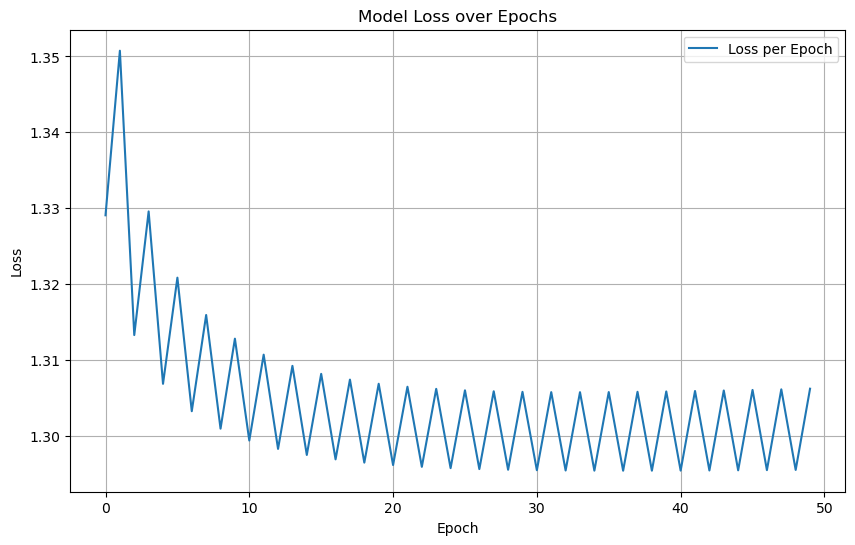

In [319]:
plot_training_loss(loss_list)

In [320]:
y_train

,successful
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
833106,1.0
833107,1.0
833108,1.0
833109,1.0


## Model Testing 

In [329]:
test(W, b, X_train, y_train,X_test, y_test)

Training Accuracy: 0.6826235776958536
Testing Accuracy: 0.6668571302991012


(0.6826235776958536, 0.6668571302991012)

## Obsolete

In [ ]:
# def Bot1(k, alpha, max_iter, timeout):
#     global grid, open_cells
#     bot, ship, open_cells = place_bot(grid, open_cells)

#     crew_list = []
#     alien_list = []
#     d_lookup_table = {}

#     crew_list, ship = place_crew(ship, open_cells, crew_list)
#     alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

#     alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#     crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)

#     win_count = 0
#     loss_count = 0
#     move = 0
#     win_move_count = []
#     marker = 0

#     while (win_count + loss_count) < max_iter:
#         neighbors = check_valid_neighbors(len(ship), bot[0], bot[1])
#         open_moves = [neigh for neigh in neighbors if (grid[neigh] != 1)]
#         open_moves.append(bot) # Bot can stay in place 
#         next_move = determine_move(open_moves, alien_matrix, crew_matrix)
        
#         prev_win_count = win_count
#         bot, crew_list, ship, open_cells, win_count, marker = move_bot(ship, bot, next_move, crew_list, alien_list, open_cells, win_count, 1)
#         move += 1

#         if marker == 1 or move >= timeout:
#             loss_count += 1
#             print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")

#             grid, open_cells = reset_grid(grid, open_cells)
#             bot, ship, open_cells = place_bot(grid, open_cells)
#             crew_list = []
#             alien_list = []
#             d_lookup_table = {}

#             crew_list, ship = place_crew(ship, open_cells, crew_list)
#             alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

#             alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#             crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
#             marker = 0
#             move = 0

#             continue

#         if win_count > prev_win_count:
#             print(f"Crew saved! Win Count: {win_count}, Loss Count: {loss_count}")
#             win_move_count.append(move)
#             move = 0
#             d_lookup_table = {}
#             alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#             crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
        
#         print(f"Bot: {bot}, Crew: {crew_list}, Aliens: {alien_list}")

#         alien_matrix, crew_matrix = update_afterbotmove(bot, alien_matrix, crew_matrix)

#         # Move bot to optimal neighbor
#         marker, alien_list, ship = move_aliens(ship, alien_list, bot) # Move alien randomly

#         if marker == 1 or move >= timeout:
#             loss_count += 1
#             print(f"Bot captured! Win Count: {win_count}, Loss Count: {loss_count}")

#             grid, open_cells = reset_grid(grid, open_cells)
#             bot, ship, open_cells = place_bot(grid, open_cells)
#             crew_list = []
#             alien_list = []
#             d_lookup_table = {}

#             crew_list, ship = place_crew(ship, open_cells, crew_list)
#             alien_list, ship = place_alien(ship, open_cells, alien_list, bot, k)

#             alien_matrix = initialize_alienmatrix(open_cells, bot, k)
#             crew_matrix = initialize_crewmatrix(open_cells, crew_list, bot)
#             marker = 0
#             move = 0

#             continue
        
#         alien_matrix = update_afteralienmove(ship, alien_list, alien_matrix) # Update after alien move
        
#         alien_detected = alien_sensor(alien_list, bot, k) # Run Alien Sensor
#         crew_detected, d_lookup_table = crew_sensor(ship, bot, alpha, d_lookup_table, crew_list) # Run Crew Sensor
        
#         alien_matrix = update_alienmatrix(alien_matrix, alien_detected, bot, k) # Update based on alien sensor

#         crew_matrix = update_crewmatrix(crew_matrix, crew_detected, d_lookup_table, bot, alpha) # Update based on crew sensor

#     return sum(win_move_count) // max(1, len(win_move_count)), (win_count / max(1, (win_count + loss_count))), win_count

In [ ]:
# def plot_Bot1(alpha_values, k_values, bot1_data, title, metric_num):
#     # Generate a plot for each k-value
#     for k in k_values:
#         plt.figure(figsize=(10, 6))
#         plt.plot(alpha_values, bot1_data[k], label=f'Bot 1, k={k}')
#         plt.title(f'{title} (k={k})')
#         plt.xlabel('alpha')
#         plt.ylabel(title)

#         # Set x-axis ticks
#         plt.xticks(alpha_values, labels=[str(alpha) for alpha in alpha_values])

#         plt.legend()
#         plt.grid(True)
        
#         plt.show()

In [ ]:
# def one_alien_one_crew(alpha_values, k_values, max_iter, timeout, num_simulations):
#     bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved = Bot1_simulation(alpha_values, k_values, max_iter, timeout, num_simulations)

#     bot1_prob_crew_rescue = {k: [round(prob, 3) for prob in probs] for k, probs in bot1_prob_crew_rescue.items()}

#     print(bot1_avg_rescue_moves, bot1_prob_crew_rescue, bot1_avg_crew_saved, "\n")

#     plot_Bot1(alpha_values, k_values, bot1_avg_rescue_moves, 'Average Rescue Moves', 1)
#     plot_Bot1(alpha_values, k_values, bot1_prob_crew_rescue, 'Probability of Crew Rescue', 2)
#     plot_Bot1(alpha_values, k_values, bot1_avg_crew_saved, 'Average Crew Saved', 3)